This notebook is for plotting snapshots plots corresponding to high and low NAO events. In particular, maps of anomlaies in wind stress, heat flux, SST, mixed-layer depth etc. are plotted.

In [1]:
# Load libraries

import numpy as np
import xarray as xr
import cf_xarray
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_sec(ax, da, vmin=-999, vmax=999, levels=9, lat_lon_ext = [-180, 180, -85., 85.],
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?', orien='vertical', colorbar=True,
            y_lab = True, x_lab = True, grid_line = True):
        
    p = da.plot.contourf(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, levels = levels, cmap=cmap, 
                         transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False, extend='both')
    
    # add separate colorbar
    if(colorbar==True):
        cb = plt.colorbar(p, ax=ax, extend='both', shrink=1.0, orientation=orien)
        cb.ax.tick_params(labelsize=12)
    
    ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    
    # parallels/meridiens
    if(grid_line == True):
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1., color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    gl.xformatter = LONGITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
    gl.ylocator = mticker.FixedLocator([70, 60, 50, 40, 30])
    gl.xlocator = mticker.FixedLocator([-80, -60, -40, -20, 0])
    
    if(y_lab==False):
        gl.ylocator = mticker.FixedLocator([])
    if(x_lab==False):
        gl.xlocator = mticker.FixedLocator([])
    
    ax.add_feature(cfeature.LAND) #facecolor='black')
    ax.add_feature(cfeature.COASTLINE)
    ax.set_aspect(1.0)

    #p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    _ = plt.title(title, fontsize=12)
    return p

In [3]:
# Read data for NAO and compute seasonal values

ppdir = "/home/users/hkhatri/DePreSys4_Data/Data_Anomaly_Compute/NAO/"

ds_NAO = xr.open_dataset(ppdir + "NAO_SLP_Anomaly_new.nc")

#NAO_season = ds_NAO['NAO'].copy()
NAO_season = (ds_NAO['P_south'] - ds_NAO['P_north']) # for NAO indices in pa

tim = ds_NAO['time_val'].isel(start_year=0).drop('start_year')
NAO_season = NAO_season.assign_coords(time=tim)

NAO_season = NAO_season.isel(time=slice(1,len(NAO_season.time)-1)) # get rid of first Nov and last Mar for better seasonal avg

%time NAO_season = NAO_season.resample(time='QS-DEC').mean('time').compute()

CPU times: user 29.7 ms, sys: 1.81 ms, total: 31.5 ms
Wall time: 35.8 ms


In [4]:
NAO_cut = 1300. # in hpa (for normalised NAO indices, use 2.5 cut-off to be consistent with other scripts)

count_NAOp = 0
count_NAOn = 0

for ind in range(4,13,4):
    
    c_NAOp = (xr.where(NAO_season.isel(time=ind) >= NAO_cut, 1, 0)).sum().values
    c_NAOn = (xr.where(NAO_season.isel(time=ind) <= -NAO_cut, 1, 0)).sum().values
    
    count_NAOp =  count_NAOp + c_NAOp
    count_NAOn =  count_NAOn + c_NAOn
    
    print('NAOp = ',c_NAOp, ', NAOn = ', c_NAOn) 

print('Total NAO positive members = ', count_NAOp)
print('Total NAO negative members = ', count_NAOn)

NAOp =  34 , NAOn =  49
NAOp =  39 , NAOn =  44
NAOp =  41 , NAOn =  40
Total NAO positive members =  114
Total NAO negative members =  133


In [7]:
# Read data (using NAO indices in hpa)

ds_NAOp = []
ds_NAOn = []

ppdir = "/gws/nopw/j04/snapdragon/hkhatri/Data_Composite/NAO_hpa/"

var_list = ['mlotst', 'tos', 'tauu', 'hfds', 'Heat_Budget_new']

case_list = ['NAOp', 'NAOn']

for case in case_list:
    
    for var in var_list:
        
        d = xr.open_mfdataset(ppdir + "Composite_" + case + "_" + var + ".nc", chunks={'time':1})
        
        if(case == 'NAOp'):
            ds_NAOp.append(d)
        elif(case == 'NAOn'):
            ds_NAOn.append(d)
            
ds_NAOp = xr.merge(ds_NAOp)
ds_NAOn = xr.merge(ds_NAOn)

ds_NAOp = ds_NAOp.mean('comp')
ds_NAOn = ds_NAOn.mean('comp')

print(ds_NAOp)

<xarray.Dataset>
Dimensions:            (j: 321, i: 361, time: 101, lat: 99, lon: 432)
Coordinates:
  * j                  (j) int32 780 781 782 783 784 ... 1097 1098 1099 1100
  * i                  (i) int32 810 811 812 813 814 ... 1167 1168 1169 1170
    latitude           (j, i) float32 dask.array<chunksize=(321, 361), meta=np.ndarray>
    longitude          (j, i) float32 dask.array<chunksize=(321, 361), meta=np.ndarray>
  * lat                (lat) float64 20.28 20.83 21.39 ... 73.61 74.17 74.72
  * lon                (lon) float64 0.0 0.8333 1.667 2.5 ... 357.5 358.3 359.2
    nav_lat            (j, i) float32 dask.array<chunksize=(321, 361), meta=np.ndarray>
    nav_lon            (j, i) float32 dask.array<chunksize=(321, 361), meta=np.ndarray>
Dimensions without coordinates: time
Data variables:
    mlotst             (time, j, i) float32 dask.array<chunksize=(1, 321, 361), meta=np.ndarray>
    tos                (time, j, i) float32 dask.array<chunksize=(1, 321, 361), meta=np

#### Figure 1

In figure 1, we plot sesonal timeseries of NAO indices for selected members (both NAO+ and NAO- cases). In addition, DJFM means of surface diagnostics are plotted to see immediate effect of NAO conditions.

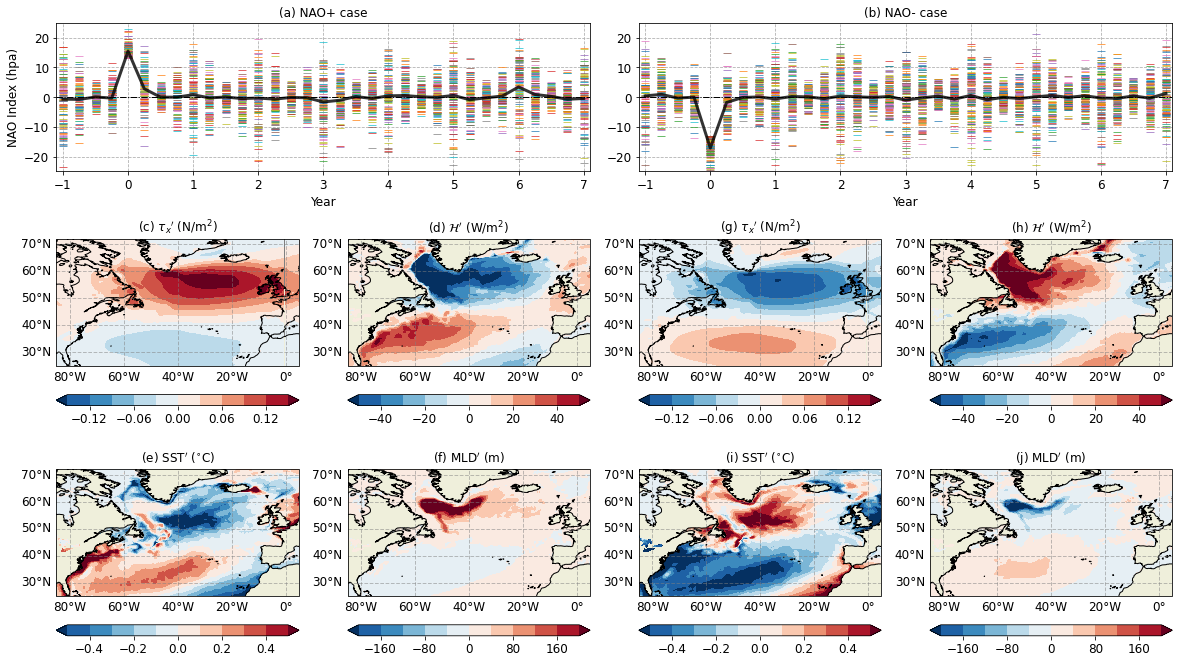

In [7]:
grid1 = plt.GridSpec(3, 4, wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=[20,12])

var_list = ['hfds', 'tos', 'mlotst'] #, 'tauu'] 
name = [r'${\tau_x}^{\prime}$ (N/m$^2$)', r'${\mathcal{H}}^{\prime}$ (W/m$^2$)', r'SST$^{\prime}$ ($^{\circ}$C)' , 'MLD$^{\prime}$ (m)']
val = [0.15, 50., 0.5, 200.]

lat_lon_ext = [-85., 5., 25., 72.]

case_list = ['NAOp', 'NAOn']
tim_ind =4

NAO_cut = 1300.

for case in case_list: 

    count = 1

    for var in var_list:

        titl = str(name[count])
        
        # get seasonl mean for the relavant data
        if (case == 'NAOp'):
            ax = fig.add_subplot(grid1[1 + int(count/2), count - int(count/2)*2], projection=ccrs.PlateCarree(),facecolor='grey')
            tmp = ds_NAOp[var].isel(time=slice(4*(tim_ind-1)+1, 4*(tim_ind-1)+2+3)).mean('time')
            titl = '(' + chr(99+count) + ') ' + str(name[count])
        elif(case == 'NAOn'):
            ax = fig.add_subplot(grid1[1 + int(count/2), count - int(count/2)*2 + 2], projection=ccrs.PlateCarree(),facecolor='grey')
            tmp = ds_NAOn[var].isel(time=slice(4*(tim_ind-1)+1, 4*(tim_ind-1)+2+3)).mean('time')
            titl = '(' + chr(103+count) + ') ' + str(name[count])
            
        p = plot_sec(ax, tmp, vmin=-val[count], vmax=val[count],  lat_lon_ext = lat_lon_ext, levels = 11,
                     lon='longitude', lat='latitude', cmap='RdBu_r', title=titl, orien='horizontal')

        count = count + 1
        
    if (case == 'NAOp'):
        ax = fig.add_subplot(grid1[1, 0], projection=ccrs.PlateCarree(),facecolor='grey')
        tmp = ds_NAOp['tauu'].isel(time=slice(4*(tim_ind-1)+1, 4*(tim_ind-1)+2+3)).mean('time')
        titl = '(c) ' + str(name[0])
    elif(case == 'NAOn'):
        ax = fig.add_subplot(grid1[1, 2], projection=ccrs.PlateCarree(),facecolor='grey')
        tmp = ds_NAOn['tauu'].isel(time=slice(4*(tim_ind-1)+1, 4*(tim_ind-1)+2+3)).mean('time')
        titl = '(g) ' + str(name[0])

    p = plot_sec(ax, tmp, vmin=-val[0], vmax=val[0],  lat_lon_ext = lat_lon_ext, levels = 11,
                 lon='lon', lat='lat', cmap='RdBu_r', title=titl, orien='horizontal')
    

for i in range(0,2):
    
    tmp_mean = []
    
    ax = fig.add_subplot(grid1[0, (0+2*i):2*(i+1)])
    
    if(i==0):
    
        for year in range(0,len(ds_NAO['start_year'])):

            for r in range(0,10):
                    
                for ind in range(4,13,4):
                    
                    tmp = NAO_season.where((NAO_season.isel(time=ind) >= NAO_cut)).isel(start_year=year, r=r)
                    tmp = tmp.isel(time = slice((int(ind/4)-1)*4, (int(ind/4) + 7)*4 + 1)) / 100. # convert to hpa
                
                    ax.plot(np.arange(0,len(tmp.time))/4 - 1, tmp, '_', ms=8, alpha=0.7)
                    
                    #ax.plot(np.arange(0,len(NAO_season.time))/4 + year*0 - (ind - 4)/4, 
                    #        NAO_season.where((NAO_season.isel(time=ind) >= 
                    #                          NAO_cut)).isel(start_year=year, r=r), '_', ms=6, color='firebrick', alpha=0.7)
                    
                    tmp_mean.append(tmp.drop(['time', 'start_year']))
                    
        tmp_mean = xr.concat(tmp_mean, dim='case')
        ax.plot(np.arange(0,len(tmp_mean.time))/4 - 1, tmp_mean.mean('case'), lw=3, color='k', alpha=0.8)
                
    elif(i==1):
        
        for year in range(0,len(ds_NAO['start_year'])):

            for r in range(0,10):
                
                for ind in range(4,13,4):
                    
                    tmp = NAO_season.where((NAO_season.isel(time=ind) <= -NAO_cut)).isel(start_year=year, r=r)
                    tmp = tmp.isel(time = slice((int(ind/4)-1)*4, (int(ind/4) + 7)*4 + 1)) / 100. # convert to hpa
                
                    ax.plot(np.arange(0,len(tmp.time))/4 - 1, tmp, '_', ms=8, alpha=0.7) 
                    
                    #ax.plot(np.arange(0,len(NAO_season.time))/4 + year*0 - (ind - 4)/4, 
                    #        NAO_season.where((NAO_season.isel(time=ind) <= 
                    #                          -NAO_cut)).isel(start_year=year, r=r),'_', ms=6, color='slateblue', alpha=0.7)
                    
                    tmp_mean.append(tmp.drop(['time', 'start_year']))
                    
        tmp_mean = xr.concat(tmp_mean, dim='case')
        ax.plot(np.arange(0,len(tmp_mean.time))/4 - 1, tmp_mean.mean('case'), lw=3, color='k', alpha=0.8)

    ax.grid('on', ls='--')
    ax.set_xlabel('Year',  fontsize=12)
    plt.yticks(fontsize = 12);
    plt.xticks(fontsize = 12);
    ax.set_ylim([-25., 25.])
    if(i==0):
        plt.title('(a) NAO+ case', fontsize=12)
        ax.axhline(y=0., ls='-.', lw=1., color='k');
        ax.set_ylabel('NAO Index (hpa)',  fontsize=12)
    if(i==1):
        plt.title('(b) NAO- case', fontsize=12)
        ax.axhline(y=-0., ls='-.', lw=1., color='k');
        
    ax.set_xlim([-1.1, 7.1])
    
    bbox=plt.gca().get_position()
    offset=.05
    plt.gca().set_position([bbox.x0 , bbox.y0 + offset*0.5, bbox.x1-bbox.x0 - offset*0.0, bbox.y1 - bbox.y0 - offset])
    
fig.savefig('/home/users/hkhatri/Plots/Figures_GRL_2022/Figure1.png', dpi=300,bbox_inches='tight');
fig.savefig('/home/users/hkhatri/Plots/Figures_GRL_2022/Figure1.pdf', dpi=300,bbox_inches='tight');

In [12]:
print(1170-810, 1100-780)

360 320


#### Figure 2

In figure 2, time evolution of anomalies in upper ocean het content, surface heat flux, SST, MLD, and overturning (both in depth and sigma space) are plotted. This is to show the long-term impacts of NAO extremes.  

In [8]:
%time ds_NAOp = ds_NAOp.compute()

tmp_ds = ds_NAOp.assign(time = ds_NAO['time_val'].isel(start_year=0, time = slice((int(4/4)-1)*12, (int(4/4) + 7)*12 + 5))).drop('start_year')

CPU times: user 1min 2s, sys: 1min 28s, total: 2min 31s
Wall time: 40min 31s


In [9]:
ppdir = "/gws/nopw/j04/snapdragon/hkhatri/Data_Composite/NAO_hpa/"

ds_psi_NAOp = xr.open_dataset(ppdir + "Composite_NAOp_Overturning.nc", chunks={'time':1})

%time ds_psi_NAOp = ds_psi_NAOp.mean('comp').compute()

ds_psi = ds_psi_NAOp.assign(time = ds_NAO['time_val'].isel(start_year=0, time = slice((int(4/4)-1)*12, (int(4/4) + 7)*12 + 5))).drop('start_year')

print(ds_psi)

CPU times: user 15.1 s, sys: 15.9 s, total: 31 s
Wall time: 9min 46s
<xarray.Dataset>
Dimensions:                (time: 101, lev: 75, j_c: 450, sigma0: 48, lat: 153)
Coordinates:
  * j_c                    (j_c) int32 699 700 701 702 ... 1145 1146 1147 1148
  * lev                    (lev) float64 0.5058 1.556 ... 5.698e+03 5.902e+03
  * sigma0                 (sigma0) float64 16.0 18.0 19.5 ... 28.9 29.5 30.5
  * lat                    (lat) float64 0.2778 0.8333 1.389 ... 84.17 84.72
  * time                   (time) object 1960-11-16 00:00:00 ... 1969-03-16 0...
Data variables:
    Overturning_z          (time, lev, j_c) float32 3.022e+04 -2.777e+04 ... 0.0
    Overturning_sigma      (time, j_c, sigma0) float32 -3.165e+03 ... 265.5
    MHT_sigma              (time, j_c, sigma0) float32 -3.666e+11 ... 0.0
    MHT_overturning_sigma  (time, j_c, sigma0) float32 -5.018e+09 ... 0.0
    MHT_z                  (time, lev, j_c) float32 -6.228e+11 ... 0.0
    MHT_overturning_z      (time, le

In [10]:
# Get correct sigma levels for overturning 

def density_levels(density_min=0., density_max=35.):
    
    """Define density levels
    Parameters
    ----------
    density_min : float value for minimum density
    density_max : float value for maximum density
    
    Returns
    -------
    sigma_levels : numpy array for density levels
    """

    density_rang1 = np.arange(density_min, 20., 2.0)
    density_rang2 = np.arange(20., 23.1, 1.)
    density_rang3 = np.arange(23.2, 26., 0.2)
    density_rang4 = np.arange(26.1, 28., 0.1)
    density_rang5 = np.arange(28.0, 28.8, 0.2)
    density_rang6 = np.arange(29.0, density_max, 1.)
    
    sigma_levels = np.concatenate((density_rang1 ,density_rang2, density_rang3, density_rang4, 
                                   density_rang5, density_rang6))
    
    return sigma_levels

# get sigma levels
sigma_min, sigma_max = (15., 31.1) 
target_sigma_levels = density_levels(density_min=sigma_min, density_max=sigma_max)

print(target_sigma_levels)

[15.  17.  19.  20.  21.  22.  23.  23.2 23.4 23.6 23.8 24.  24.2 24.4
 24.6 24.8 25.  25.2 25.4 25.6 25.8 26.  26.1 26.2 26.3 26.4 26.5 26.6
 26.7 26.8 26.9 27.  27.1 27.2 27.3 27.4 27.5 27.6 27.7 27.8 27.9 28.
 28.2 28.4 28.6 28.8 29.  30.  31. ]


In [26]:
rng_nl = target_sigma_levels[1:] * np.arange(0, len(ds_psi['sigma0']))**2
print(rng_nl.shape)

print([target_sigma_levels[16], target_sigma_levels[26], target_sigma_levels[31], target_sigma_levels[34], target_sigma_levels[37]])

(48,)
[24.999999999999993, 26.500000000000007, 27.000000000000014, 27.30000000000002, 27.600000000000023]


In [45]:
# corret levels of depth for overturning

lev_bound = xr.open_dataset("/home/users/hkhatri/DePreSys4_Data/Test_Data/nemo_av830o_1m_19810301-19810401_diaptr.nc")

#level_outer_data = (cf_xarray.bounds_to_vertices(lev_bound['deptht_bounds'].chunk({'lev':-1}),
#                                                         'bnds').load().data)

dz = lev_bound['deptht_bounds'].diff('axis_nbounds').compute()
print(dz.isel(axis_nbounds=0).values[0:5])

[1.0239066 1.0792834 1.1481192 1.2337434 1.3401852]


In [63]:
ds_psi['latitude'].values[225:302] # lat range for saving vertical sections of heat and salt

print(ds_psi['latitude'].isel(j_c.values

array([49.965893, 50.13739 , 50.295403, 50.446728, 50.603874, 50.744545,
       50.893993, 51.028095, 51.15995 , 51.30838 , 51.444977, 51.556362,
       51.664707, 51.802647, 51.92951 , 52.00489 , 52.134052, 52.244106,
       52.372482, 52.501366, 52.59139 , 52.698235, 52.76892 , 52.88495 ,
       52.991905, 53.10377 , 53.237946, 53.388355, 53.45447 , 53.526386,
       53.665325, 53.815098, 53.936493, 54.02541 , 54.15749 , 54.284782,
       54.46875 , 54.566425, 54.668392, 54.758064, 54.780262, 54.913788,
       55.017025, 55.15914 , 55.253193, 55.303112, 55.357674, 55.492413,
       55.606792, 55.744373, 55.830246, 56.015736, 56.224926, 56.424953,
       56.606457, 56.716846, 56.84201 , 57.00771 , 57.162926, 57.327785,
       57.425953, 57.616707, 57.773468, 57.908447, 58.043346, 58.192364,
       58.33606 , 58.485218, 58.637703, 58.708805, 58.817345, 58.93507 ,
       59.119892, 59.374485, 59.65223 , 59.859203, 60.131676],
      dtype=float32)

In [92]:
ds_NAOp['latitude'].where(ds_NAOp['latitude']>=50.).sel(j=slice(850,986))

<xarray.DataArray 'latitude' (j: 137, i: 361)>
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [55.80468 , 55.832592, 55.860695, ..., 59.04883 , 59.008327,
        58.96757 ],
       [55.90221 , 55.930363, 55.95871 , ..., 59.180973, 59.140186,
        59.099136],
       [55.999332, 56.027725, 56.056313, ..., 59.312862, 59.271786,
        59.230446]], dtype=float32)
Coordinates:
  * j          (j) int32 850 851 852 853 854 855 856 ... 981 982 983 984 985 986
  * i          (i) int32 810 811 812 813 814 815 ... 1166 1167 1168 1169 1170
    latitude   (j, i) float32 37.9 37.9 37.91 37.91 ... 59.35 59.31 59.27 59.23
    longitude  (j, i) float32 -84.58 -84.33 -84.08 -83.83 ... 9.875 10.14 10.41
    nav_lat    (j, i) float32 37.9 37.9 37.91 37.91 ... 59.35 59.31 59.27 59.23
    nav_lon    (j, i) float32 -84.58 -84.33 -84.08 -83.83 ... 9.875 10.14 10.41
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    bounds:         vertices_latitude

In [90]:
ds_NAOp['latitude'].mean('i').sel(j=slice(916,986))

<xarray.DataArray 'latitude' (j: 71)>
array([49.913673, 50.0724  , 50.230675, 50.388508, 50.545902, 50.702854,
       50.859375, 51.015453, 51.17111 , 51.32633 , 51.481117, 51.635487,
       51.78943 , 51.942947, 52.09605 , 52.248734, 52.401   , 52.55286 ,
       52.704304, 52.85534 , 53.005966, 53.156185, 53.306007, 53.45543 ,
       53.604446, 53.753075, 53.9013  , 54.049137, 54.196583, 54.343643,
       54.490314, 54.636604, 54.78251 , 54.928032, 55.07318 , 55.21795 ,
       55.36235 , 55.506374, 55.65003 , 55.793316, 55.936234, 56.07879 ,
       56.22099 , 56.362816, 56.504295, 56.64541 , 56.786175, 56.926586,
       57.066643, 57.20636 , 57.34572 , 57.48474 , 57.62342 , 57.761753,
       57.899742, 58.037403, 58.17472 , 58.31171 , 58.448357, 58.584682,
       58.720676, 58.85634 , 58.99168 , 59.126698, 59.261387, 59.395763,
       59.52981 , 59.663555, 59.796974, 59.930077, 60.062866],
      dtype=float32)
Coordinates:
  * j        (j) int32 916 917 918 919 920 921 922 ... 981 982 983 984 985 986

In [69]:
ds_NAOp['j']

<xarray.DataArray 'j' (j: 321)>
array([ 780,  781,  782, ..., 1098, 1099, 1100], dtype=int32)
Coordinates:
  * j        (j) int32 780 781 782 783 784 785 ... 1095 1096 1097 1098 1099 1100
Attributes:
    units:      1
    long_name:  cell index along second dimension

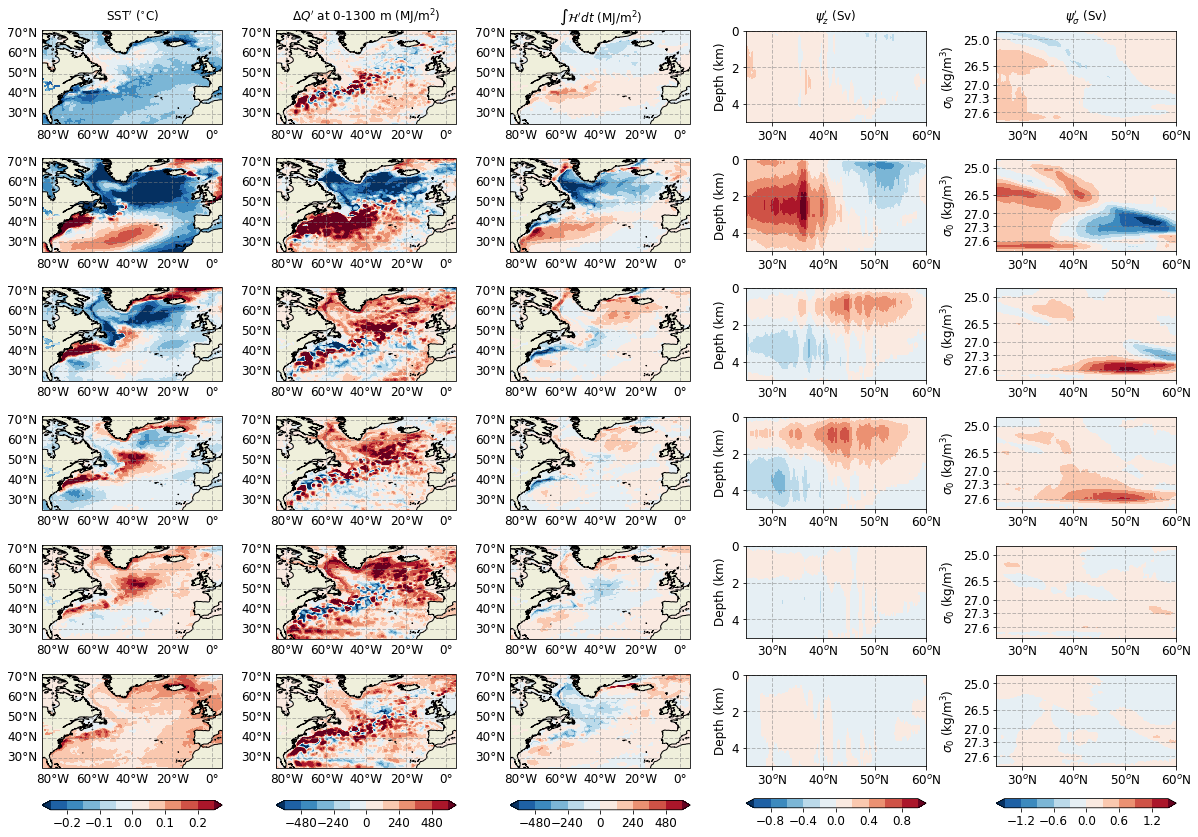

In [54]:
# Plot heat content anomalies with 12-month moving average for NAO+ case

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

lat_lon_ext = [-85., 5., 25., 72.]

grid1 = plt.GridSpec(6, 5, wspace=0.3, hspace=0.1)
fig = plt.figure(figsize=[20,14])

#tmp_ds = xr.merge([HB_NAOp, ds_NAOp.get(['tos','mlotst'])])

name = [r'$\Delta Q^{\prime}$ at 0-1300 m (MJ/m$^2$)', r'$\int {\mathcal{H}}^{\prime} dt$ (MJ/m$^2$)', 
        r'SST$^{\prime}$ ($^{\circ}$C)' , 'MLD$^{\prime}$ (m) in JFM', r'$\psi_z^{\prime}$ (Sv)', r'$\psi_{\sigma}^{\prime}$ (Sv)']

ax1 = []

ind_correct = 0
for i in range(0,6):
    
    tmp1 = tmp_ds['Heat_Content_1300']
    
    if (i<=3):
        #tmp = (tmp1.isel(time=slice(12*i + 2, 12*i + 2 + 12)).mean('time') - 0*tmp1.isel(time=1))/1e6 # anomaly from Dec (2nd month)
        tmp = (tmp1.isel(time=12*i + 2 + 11) - tmp1.isel(time=12*i + 1))/1e6
    #elif (i==3):
    else:
        #tmp = (tmp1.isel(time=slice(12*i + 2, 12*(i+1) + 2 + 12)).mean('time') - 0*tmp1.isel(time=1))/1e6 # anomaly from Dec (2nd month)
        tmp = (tmp1.isel(time=12*(i + 1 + ind_correct) + 2 + 11) - tmp1.isel(time=12*(i + ind_correct) + 1))/1e6
        ind_correct = ind_correct + 1
    #else:
        #tmp = (tmp1.isel(time=slice(12*i + 2, 12*(i+2) + 2 + 12)).mean('time') - 0*tmp1.isel(time=1))/1e6 # anomaly from Dec (2nd month)
    #    tmp = (tmp1.isel(time=12*(i+2) + 2 + 11) - tmp1.isel(time=12*i + 1))/1e6
                    
    tmp = tmp.where(tmp_ds['tos'].isel(time=0) < 100.) # mask 0s on land
    
    if(i==5):
        xlab = True
    else:
        xlab = False 
        
    if(i==0):
        titl = str(name[0])
    else: 
        titl = ' '
    
    ax = fig.add_subplot(grid1[i, 1], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, tmp, vmin=-600., vmax=600.,  lat_lon_ext = lat_lon_ext, levels = 11,
                 lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title=titl, orien='horizontal',
                colorbar=False, y_lab = True, x_lab = True)
    
    ax1.append(ax)

axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                   bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)

ind_correct = 0
for i in range(0,6):
    
    tmp1 = tmp_ds['hfds']
    
    if (i<=3):
        tmp = (tmp1.isel(time=slice(12*i + 2, 12*i + 2 + 12)).sum('time')) * 30. * 24 * 3600. / 1e6
    else:
        tmp = (tmp1.isel(time=slice(12*i + ind_correct + 2, 12*(i + ind_correct + 1) + 2 + 3)).sum('time')) * 30. * 24 * 3600. / 1e6
        ind_correct = ind_correct + 1
    
    if(i==5):
        xlab = True
    else:
        xlab = False 
        
    if(i==0):
        titl = str(name[1])
    else: 
        titl = ' '
    
    tmp = tmp.where(tmp_ds['tos'].isel(time=0) <100.)
    
    ax = fig.add_subplot(grid1[i, 2], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, tmp, vmin=-600., vmax=600.,  lat_lon_ext = lat_lon_ext, levels = 11,
                lon='longitude', lat='latitude', cmap='RdBu_r', title=titl,  
                orien='horizontal', colorbar=False, y_lab = True, x_lab = True)
    
axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                   bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)

ind_correct = 0
for i in range(0,6):
    
    tmp1 = tmp_ds['tos']
    
    if (i<=3):
        tmp = (tmp1.isel(time=slice(12*i + 2, 12*i + 2 + 12)).mean('time') - 0*tmp1.isel(time=1)) # anomaly from Dec (2nd month)
    else:
        tmp = (tmp1.isel(time=slice(12*i + 2 + ind_correct, 12*(i + 1 + ind_correct) + 2 + 12)).mean('time') - 0*tmp1.isel(time=1)) # anomaly from Dec (2nd month)
        ind_correct = ind_correct + 1
    
    if(i==5):
        xlab = True
    else:
        xlab = False 
    
    if(i==0):
        titl = str(name[2])
    else: 
        titl = ' '
        
    ax = fig.add_subplot(grid1[i, 0], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, tmp, vmin=-0.25, vmax=0.25,  lat_lon_ext = lat_lon_ext, levels = 11,
                lon='longitude', lat='latitude', cmap='RdBu_r', title=titl,  
                orien='horizontal', colorbar=False, y_lab = True, x_lab = True)
    
axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                   bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)

ind_correct = 0
for i in range(0,6):
    
    tmp1 = ds_psi['Overturning_z']
    
    if (i<=3):
        tmp = (tmp1.isel(time=slice(12*i + 2, 12*i + 2 + 12)).mean('time') - 0*tmp1.isel(time=1))/1e6 # anomaly from Dec (2nd month)
    else:
        tmp = (tmp1.isel(time=slice(12*i + 2 + ind_correct, 12*(i + 1 + ind_correct) + 2 + 12)).mean('time') - 0*tmp1.isel(time=1))/1e6 # anomaly from Dec (2nd month)
        ind_correct = ind_correct + 1
    
    tmp = tmp.isel(j_c=slice(0,303)) #/ 1e6
    tmp = tmp.assign_coords(j_c=ds_psi['latitude'].isel(j_c=slice(0,303)))
    
    tmp = tmp.drop('lev').assign_coords(lev=ds_psi['lev'].values + dz.isel(axis_nbounds=0).values * 0.5) 
    
    if(i==0):
        titl = str(name[4])
    else: 
        titl = ' '
        
    
    ax = fig.add_subplot(grid1[i, 3])
    p = tmp.plot.contourf(ax=ax, x='j_c', y='lev', levels = 11, vmin = -1.0, vmax = 1.0,
                          cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
    ax.set_ylabel('Depth (km)', fontsize=12)
    plt.xticks(np.arange(30,61,10), [r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N'])
    plt.yticks(np.arange(0,5000,2000), [r'0', r'2', r'4'])
    ax.set_ylim([0., 5000.])
    ax.set_xlim([25., 60.])
    ax.grid(color='gray', alpha=0.5, linestyle='--', lw=1.)
    #plt.title(titl, fontsize=12)
    ax.set_title(titl, pad=10, fontsize=12)
    plt.gca().invert_yaxis()
    
    plt.yticks(fontsize = 12);
    plt.xticks(fontsize = 12);
    
    bbox=plt.gca().get_position()
    offset=.025
    plt.gca().set_position([bbox.x0 + offset*0.05, bbox.y0 + offset*0.5, bbox.x1-bbox.x0, bbox.y1 - bbox.y0 - offset])
    
axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                   bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)

ind_correct = 0
for i in range(0,6):
    
    tmp1 = ds_psi['Overturning_sigma']
    
    if (i<=3):
        tmp = (tmp1.isel(time=slice(12*i + 2, 12*i + 2 + 12)).mean('time') - 0*tmp1.isel(time=1))/1e6 # anomaly from Dec (2nd month)
    else:
        tmp = (tmp1.isel(time=slice(12*i + 2 + ind_correct, 12*(i + 1 + ind_correct) + 2 + 12)).mean('time') - 0*tmp1.isel(time=1))/1e6 # anomaly from Dec (2nd month)
        ind_correct = ind_correct + 1
    
    tmp = tmp.isel(j_c=slice(0,303)) #/ 1e6
    tmp = tmp.assign_coords(j_c=ds_psi['latitude'].isel(j_c=slice(0,303)))
    
    #rng_nl = ds_psi['sigma0']* np.arange(0, len(ds_psi['sigma0']))**2
    rng_nl = target_sigma_levels[1:] * np.arange(0, len(ds_psi['sigma0']))**2
    tmp = tmp.drop('sigma0').assign_coords(sigma0 = rng_nl)
    
    if(i==0):
        titl = str(name[5]) #+ '\n \n (e1)'  
    else: 
        titl = ' ' #(e' + str(i+1) + ')'
        
    
    ax = fig.add_subplot(grid1[i, 4])
    p = tmp.plot.contourf(ax=ax, x='j_c', y='sigma0', levels = 11, vmin = -1.5, vmax = 1.5,
                          cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
    ax.set_ylabel(r'$\sigma_0$ (kg/m$^3$)', fontsize=12)
    plt.xticks(np.arange(30,61,10), [r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N'])
    #ax.set_ylim([27., 27.8])
    ax.set_ylim([2000., 40000.])
    plt.yticks([rng_nl[15], rng_nl[25], rng_nl[30], rng_nl[33], rng_nl[36]], [25.0, 26.5, 27.0, 27.3, 27.6])
    #plt.yticks([15.5**2 * 25., 25.5**2*26.5, 30.5**2*27, 33.5**2*27.3, 36.5**2*27.6], [25.0, 26.5, 27.0, 27.3, 27.6])
    #plt.yticks([15.**2 * 25., 25.**2*26.5, 30.**2*27, 33.**2*27.3, 36.**2*27.6], [25.0, 26.5, 27.0, 27.3, 27.6])
    
    ax.set_xlim([25., 60.])
    ax.grid(color='gray', alpha=0.5, linestyle='--', lw=1.)
    ax.set_title(titl, pad=10, fontsize=12)
    plt.gca().invert_yaxis()
    
    plt.yticks(fontsize = 12);
    plt.xticks(fontsize = 12);
    
    bbox=plt.gca().get_position()
    offset=.025
    plt.gca().set_position([bbox.x0 + offset*0.5, bbox.y0 + offset*0.5, bbox.x1-bbox.x0, bbox.y1 - bbox.y0 - offset])
    
axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                   bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)

fig.savefig('/home/users/hkhatri/Plots/Figures_GRL_2022/Figure2.png', dpi=300,bbox_inches='tight');
fig.savefig('/home/users/hkhatri/Plots/Figures_GRL_2022/Figure2.pdf', dpi=300,bbox_inches='tight');

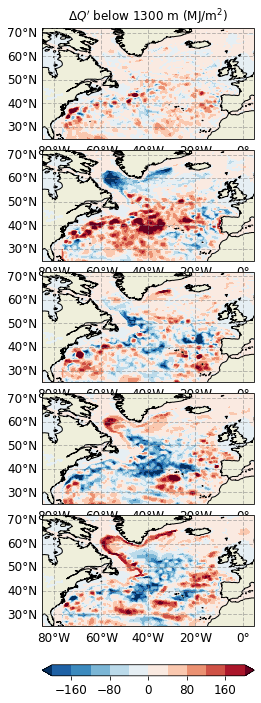

In [11]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

lat_lon_ext = [-85., 5., 25., 72.]

grid1 = plt.GridSpec(5, 1, wspace=0.3, hspace=0.1)
fig = plt.figure(figsize=[4,11])

for i in range(0,5):
    
    tmp1 = tmp_ds['Heat_Content'] - tmp_ds['Heat_Content_200'] - tmp_ds['Heat_Content_1300']
    
    if (i<=2):
        #tmp = (tmp1.isel(time=slice(12*i + 2, 12*i + 2 + 12)).mean('time') - 0*tmp1.isel(time=1))/1e6 # anomaly from Dec (2nd month)
        tmp = (tmp1.isel(time=12*i + 2 + 11) - tmp1.isel(time=12*i + 1))/1e6
    elif (i==3):
        #tmp = (tmp1.isel(time=slice(12*i + 2, 12*(i+1) + 2 + 12)).mean('time') - 0*tmp1.isel(time=1))/1e6 # anomaly from Dec (2nd month)
        tmp = (tmp1.isel(time=12*(i+1) + 2 + 11) - tmp1.isel(time=12*i + 1))/1e6
    else:
        #tmp = (tmp1.isel(time=slice(12*i + 2, 12*(i+2) + 2 + 12)).mean('time') - 0*tmp1.isel(time=1))/1e6 # anomaly from Dec (2nd month)
        tmp = (tmp1.isel(time=12*(i+2) + 2 + 11) - tmp1.isel(time=12*i + 1))/1e6
                    
    tmp = tmp.where(tmp_ds['tos'].isel(time=0) < 100.) # mask 0s on land
    
    if(i==4):
        xlab = True
    else:
        xlab = False 
        
    if(i==0):
        titl = r'$\Delta Q^{\prime}$ below 1300 m (MJ/m$^2$)'
    else: 
        titl = ' '
    
    ax = fig.add_subplot(grid1[i, 0], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, tmp, vmin=-200., vmax=200.,  lat_lon_ext = lat_lon_ext, levels = 11,
                 lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title=titl, orien='horizontal',
                colorbar=False, y_lab = True, x_lab = True)

axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                   bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)

In [ ]:
"""
for i in range(0,5):
    
    tmp1 = tmp_ds['mlotst']
    
    if (i<=2):
        tmp = (tmp1.isel(time=slice(12*i + 2, 12*i + 2 + 3)).mean('time')) 
    elif (i==3):
        tmp = (tmp1.isel(time=slice(12*i + 2, 12*(i+1) + 2 + 3)).where(tmp1['time.month']<=3).mean('time'))
    else:
        tmp = (tmp1.isel(time=slice(12*i + 2, 12*(i+2) + 2 + 3)).where(tmp1['time.month']<=3).mean('time'))
    
    if(i==4):
        xlab = True
    else:
        xlab = False
        
    if(i==0):
        titl = str(name[3])
    else: 
        titl = ' '
        
    ax = fig.add_subplot(grid1[i, 3], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, tmp, vmin=-200., vmax=200.,  lat_lon_ext = lat_lon_ext, levels = 11,
                lon='longitude', lat='latitude', cmap='RdBu_r', title=titl,  
                orien='horizontal', colorbar=False, y_lab = True, x_lab = True)
    
axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                   bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)
"""

#### Fiture 2 supporting document

Same as Figure 2 but for NAO- case 

In [93]:
%time ds_NAOn = ds_NAOn.compute()

tmp_ds = ds_NAOn.assign(time = ds_NAO['time_val'].isel(start_year=0, time = slice((int(4/4)-1)*12, (int(4/4) + 7)*12 + 5))).drop('start_year')

CPU times: user 1min 13s, sys: 1min 50s, total: 3min 4s
Wall time: 51min 45s


In [94]:
ppdir = "/gws/nopw/j04/snapdragon/hkhatri/Data_Composite/NAO_hpa/"

ds_psi_NAOn = xr.open_dataset(ppdir + "Composite_NAOn_Overturning.nc", chunks={'time':1})

%time ds_psi_NAOn = ds_psi_NAOn.mean('comp').compute()

ds_psi = ds_psi_NAOn.assign(time = ds_NAO['time_val'].isel(start_year=0, time = slice((int(4/4)-1)*12, (int(4/4) + 7)*12 + 5))).drop('start_year')

print(ds_psi)

CPU times: user 15.8 s, sys: 15.1 s, total: 31 s
Wall time: 12min 12s
<xarray.Dataset>
Dimensions:                (time: 101, lev: 75, j_c: 450, sigma0: 48, lat: 153)
Coordinates:
  * j_c                    (j_c) int32 699 700 701 702 ... 1145 1146 1147 1148
  * lev                    (lev) float64 0.5058 1.556 ... 5.698e+03 5.902e+03
  * sigma0                 (sigma0) float64 16.0 18.0 19.5 ... 28.9 29.5 30.5
  * lat                    (lat) float64 0.2778 0.8333 1.389 ... 84.17 84.72
  * time                   (time) object 1960-11-16 00:00:00 ... 1969-03-16 0...
Data variables:
    Overturning_z          (time, lev, j_c) float32 -4.354e+05 -3.66e+05 ... 0.0
    Overturning_sigma      (time, j_c, sigma0) float32 1.009e+04 ... 4.995e+04
    MHT_sigma              (time, j_c, sigma0) float32 1.144e+12 ... 0.0
    MHT_overturning_sigma  (time, j_c, sigma0) float32 1.719e+10 ... 0.0
    MHT_z                  (time, lev, j_c) float32 7.558e+10 2.809e+11 ... 0.0
    MHT_overturning_z    

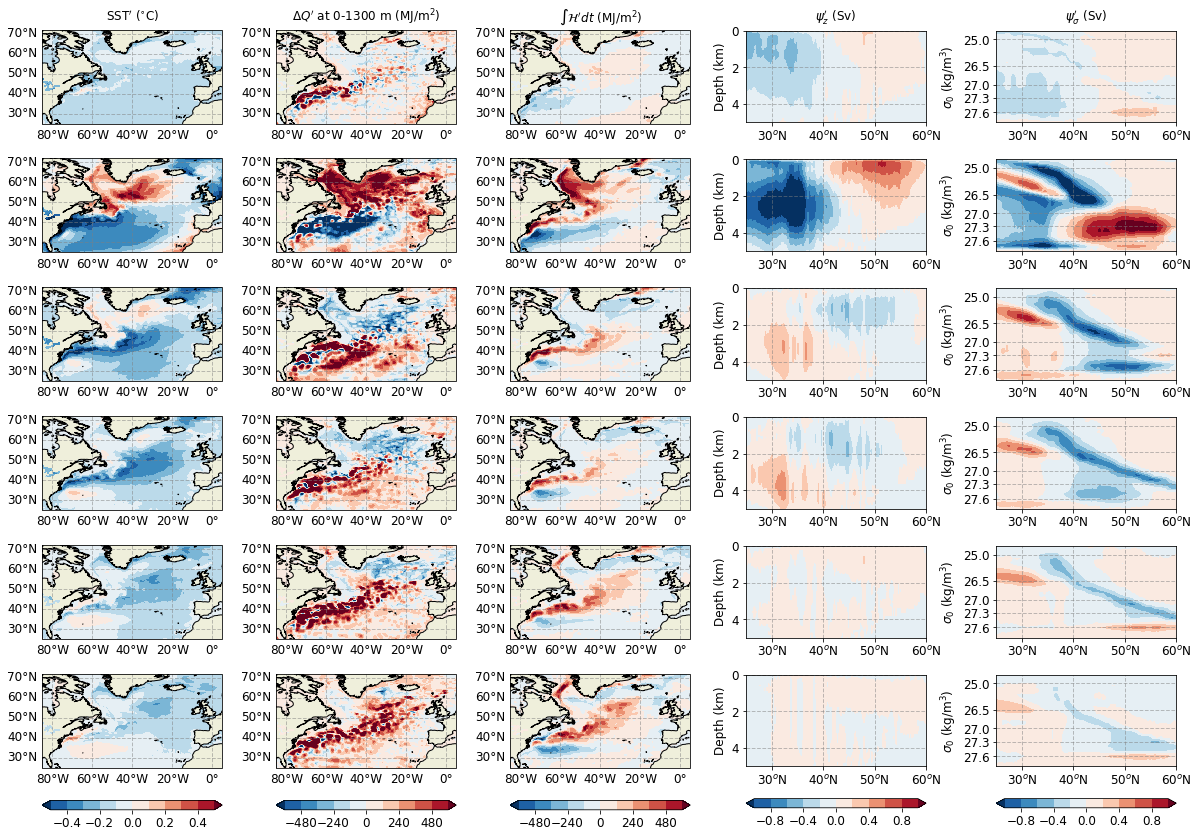

In [97]:
# Plot heat content anomalies with 12-month moving average for NAO+ case

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

lat_lon_ext = [-85., 5., 25., 72.]

grid1 = plt.GridSpec(6, 5, wspace=0.3, hspace=0.1)
fig = plt.figure(figsize=[20,14])

#tmp_ds = xr.merge([HB_NAOp, ds_NAOp.get(['tos','mlotst'])])

name = [r'$\Delta Q^{\prime}$ at 0-1300 m (MJ/m$^2$)', r'$\int {\mathcal{H}}^{\prime} dt$ (MJ/m$^2$)', 
        r'SST$^{\prime}$ ($^{\circ}$C)' , 'MLD$^{\prime}$ (m) in JFM', r'$\psi_z^{\prime}$ (Sv)', r'$\psi_{\sigma}^{\prime}$ (Sv)']

ax1 = []

ind_correct = 0
for i in range(0,6):
    
    tmp1 = tmp_ds['Heat_Content_1300']
    
    if (i<=3):
        #tmp = (tmp1.isel(time=slice(12*i + 2, 12*i + 2 + 12)).mean('time') - 0*tmp1.isel(time=1))/1e6 # anomaly from Dec (2nd month)
        tmp = (tmp1.isel(time=12*i + 2 + 11) - tmp1.isel(time=12*i + 1))/1e6
    #elif (i==3):
    else:
        #tmp = (tmp1.isel(time=slice(12*i + 2, 12*(i+1) + 2 + 12)).mean('time') - 0*tmp1.isel(time=1))/1e6 # anomaly from Dec (2nd month)
        tmp = (tmp1.isel(time=12*(i + 1 + ind_correct) + 2 + 11) - tmp1.isel(time=12*(i + ind_correct) + 1))/1e6
        ind_correct = ind_correct + 1
    #else:
        #tmp = (tmp1.isel(time=slice(12*i + 2, 12*(i+2) + 2 + 12)).mean('time') - 0*tmp1.isel(time=1))/1e6 # anomaly from Dec (2nd month)
    #    tmp = (tmp1.isel(time=12*(i+2) + 2 + 11) - tmp1.isel(time=12*i + 1))/1e6
                    
    tmp = tmp.where(tmp_ds['tos'].isel(time=0) < 100.) # mask 0s on land
    
    if(i==5):
        xlab = True
    else:
        xlab = False 
        
    if(i==0):
        titl = str(name[0])
    else: 
        titl = ' '
    
    ax = fig.add_subplot(grid1[i, 1], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, tmp, vmin=-600., vmax=600.,  lat_lon_ext = lat_lon_ext, levels = 11,
                 lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title=titl, orien='horizontal',
                colorbar=False, y_lab = True, x_lab = True)
    
    ax1.append(ax)

axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                   bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)

ind_correct = 0
for i in range(0,6):
    
    tmp1 = tmp_ds['hfds']
    
    if (i<=3):
        tmp = (tmp1.isel(time=slice(12*i + 2, 12*i + 2 + 12)).sum('time')) * 30. * 24 * 3600. / 1e6
    else:
        tmp = (tmp1.isel(time=slice(12*i + ind_correct + 2, 12*(i + ind_correct + 1) + 2 + 3)).sum('time')) * 30. * 24 * 3600. / 1e6
        ind_correct = ind_correct + 1
    
    if(i==5):
        xlab = True
    else:
        xlab = False 
        
    if(i==0):
        titl = str(name[1])
    else: 
        titl = ' '
    
    tmp = tmp.where(tmp_ds['tos'].isel(time=0) <100.)
    
    ax = fig.add_subplot(grid1[i, 2], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, tmp, vmin=-600., vmax=600.,  lat_lon_ext = lat_lon_ext, levels = 11,
                lon='longitude', lat='latitude', cmap='RdBu_r', title=titl,  
                orien='horizontal', colorbar=False, y_lab = True, x_lab = True)
    
axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                   bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)

ind_correct = 0
for i in range(0,6):
    
    tmp1 = tmp_ds['tos']
    
    if (i<=3):
        tmp = (tmp1.isel(time=slice(12*i + 2, 12*i + 2 + 12)).mean('time') - 0*tmp1.isel(time=1)) # anomaly from Dec (2nd month)
    else:
        tmp = (tmp1.isel(time=slice(12*i + 2 + ind_correct, 12*(i + 1 + ind_correct) + 2 + 12)).mean('time') - 0*tmp1.isel(time=1)) # anomaly from Dec (2nd month)
        ind_correct = ind_correct + 1
    
    if(i==5):
        xlab = True
    else:
        xlab = False 
    
    if(i==0):
        titl = str(name[2])
    else: 
        titl = ' '
        
    ax = fig.add_subplot(grid1[i, 0], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, tmp, vmin=-0.5, vmax=0.5,  lat_lon_ext = lat_lon_ext, levels = 11,
                lon='longitude', lat='latitude', cmap='RdBu_r', title=titl,  
                orien='horizontal', colorbar=False, y_lab = True, x_lab = True)
    
axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                   bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)

ind_correct = 0
for i in range(0,6):
    
    tmp1 = ds_psi['Overturning_z']
    
    if (i<=3):
        tmp = (tmp1.isel(time=slice(12*i + 2, 12*i + 2 + 12)).mean('time') - 0*tmp1.isel(time=1))/1e6 # anomaly from Dec (2nd month)
    else:
        tmp = (tmp1.isel(time=slice(12*i + 2 + ind_correct, 12*(i + 1 + ind_correct) + 2 + 12)).mean('time') - 0*tmp1.isel(time=1))/1e6 # anomaly from Dec (2nd month)
        ind_correct = ind_correct + 1
    
    tmp = tmp.isel(j_c=slice(0,303)) #/ 1e6
    tmp = tmp.assign_coords(j_c=ds_psi['latitude'].isel(j_c=slice(0,303)))
    
    tmp = tmp.drop('lev').assign_coords(lev=ds_psi['lev'].values + dz.isel(axis_nbounds=0).values * 0.5) 
    
    if(i==0):
        titl = str(name[4])
    else: 
        titl = ' '
        
    
    ax = fig.add_subplot(grid1[i, 3])
    p = tmp.plot.contourf(ax=ax, x='j_c', y='lev', levels = 11, vmin = -1.0, vmax = 1.0,
                          cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
    ax.set_ylabel('Depth (km)', fontsize=12)
    plt.xticks(np.arange(30,61,10), [r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N'])
    plt.yticks(np.arange(0,5000,2000), [r'0', r'2', r'4'])
    ax.set_ylim([0., 5000.])
    ax.set_xlim([25., 60.])
    ax.grid(color='gray', alpha=0.5, linestyle='--', lw=1.)
    #plt.title(titl, fontsize=12)
    ax.set_title(titl, pad=10, fontsize=12)
    plt.gca().invert_yaxis()
    
    plt.yticks(fontsize = 12);
    plt.xticks(fontsize = 12);
    
    bbox=plt.gca().get_position()
    offset=.025
    plt.gca().set_position([bbox.x0 + offset*0.05, bbox.y0 + offset*0.5, bbox.x1-bbox.x0, bbox.y1 - bbox.y0 - offset])
    
axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                   bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)

ind_correct = 0
for i in range(0,6):
    
    tmp1 = ds_psi['Overturning_sigma']
    
    if (i<=3):
        tmp = (tmp1.isel(time=slice(12*i + 2, 12*i + 2 + 12)).mean('time') - 0*tmp1.isel(time=1))/1e6 # anomaly from Dec (2nd month)
    else:
        tmp = (tmp1.isel(time=slice(12*i + 2 + ind_correct, 12*(i + 1 + ind_correct) + 2 + 12)).mean('time') - 0*tmp1.isel(time=1))/1e6 # anomaly from Dec (2nd month)
        ind_correct = ind_correct + 1
    
    tmp = tmp.isel(j_c=slice(0,303)) #/ 1e6
    tmp = tmp.assign_coords(j_c=ds_psi['latitude'].isel(j_c=slice(0,303)))
    
    #rng_nl = ds_psi['sigma0']* np.arange(0, len(ds_psi['sigma0']))**2
    rng_nl = target_sigma_levels[1:] * np.arange(0, len(ds_psi['sigma0']))**2
    tmp = tmp.drop('sigma0').assign_coords(sigma0 = rng_nl)
    
    if(i==0):
        titl = str(name[5]) #+ '\n \n (e1)'  
    else: 
        titl = ' ' #(e' + str(i+1) + ')'
        
    
    ax = fig.add_subplot(grid1[i, 4])
    p = tmp.plot.contourf(ax=ax, x='j_c', y='sigma0', levels = 11, vmin = -1., vmax = 1.,
                          cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
    ax.set_ylabel(r'$\sigma_0$ (kg/m$^3$)', fontsize=12)
    plt.xticks(np.arange(30,61,10), [r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N'])
    #ax.set_ylim([27., 27.8])
    ax.set_ylim([2000., 40000.])
    plt.yticks([rng_nl[15], rng_nl[25], rng_nl[30], rng_nl[33], rng_nl[36]], [25.0, 26.5, 27.0, 27.3, 27.6])
    #plt.yticks([15.5**2 * 25., 25.5**2*26.5, 30.5**2*27, 33.5**2*27.3, 36.5**2*27.6], [25.0, 26.5, 27.0, 27.3, 27.6])
    #plt.yticks([15.**2 * 25., 25.**2*26.5, 30.**2*27, 33.**2*27.3, 36.**2*27.6], [25.0, 26.5, 27.0, 27.3, 27.6])
    
    ax.set_xlim([25., 60.])
    ax.grid(color='gray', alpha=0.5, linestyle='--', lw=1.)
    ax.set_title(titl, pad=10, fontsize=12)
    plt.gca().invert_yaxis()
    
    plt.yticks(fontsize = 12);
    plt.xticks(fontsize = 12);
    
    bbox=plt.gca().get_position()
    offset=.025
    plt.gca().set_position([bbox.x0 + offset*0.5, bbox.y0 + offset*0.5, bbox.x1-bbox.x0, bbox.y1 - bbox.y0 - offset])
    
axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                   bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)

fig.savefig('/home/users/hkhatri/Plots/Figures_GRL_2022/Figure2_support.png', dpi=300,bbox_inches='tight');
fig.savefig('/home/users/hkhatri/Plots/Figures_GRL_2022/Figure2_support.pdf', dpi=300,bbox_inches='tight');

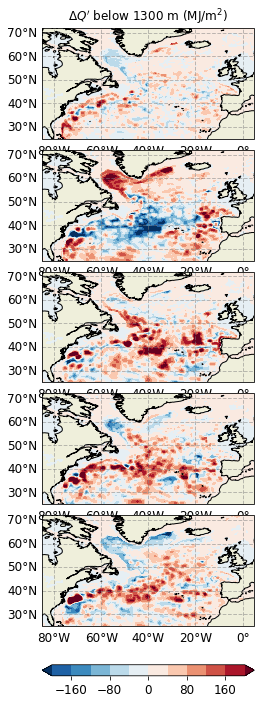

In [13]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

lat_lon_ext = [-85., 5., 25., 72.]

grid1 = plt.GridSpec(5, 1, wspace=0.3, hspace=0.1)
fig = plt.figure(figsize=[4,11])

for i in range(0,5):
    
    tmp1 = tmp_ds['Heat_Content'] - tmp_ds['Heat_Content_200'] - tmp_ds['Heat_Content_1300']
    
    if (i<=2):
        #tmp = (tmp1.isel(time=slice(12*i + 2, 12*i + 2 + 12)).mean('time') - 0*tmp1.isel(time=1))/1e6 # anomaly from Dec (2nd month)
        tmp = (tmp1.isel(time=12*i + 2 + 11) - tmp1.isel(time=12*i + 1))/1e6
    elif (i==3):
        #tmp = (tmp1.isel(time=slice(12*i + 2, 12*(i+1) + 2 + 12)).mean('time') - 0*tmp1.isel(time=1))/1e6 # anomaly from Dec (2nd month)
        tmp = (tmp1.isel(time=12*(i+1) + 2 + 11) - tmp1.isel(time=12*i + 1))/1e6
    else:
        #tmp = (tmp1.isel(time=slice(12*i + 2, 12*(i+2) + 2 + 12)).mean('time') - 0*tmp1.isel(time=1))/1e6 # anomaly from Dec (2nd month)
        tmp = (tmp1.isel(time=12*(i+2) + 2 + 11) - tmp1.isel(time=12*i + 1))/1e6
                    
    tmp = tmp.where(tmp_ds['tos'].isel(time=0) < 100.) # mask 0s on land
    
    if(i==4):
        xlab = True
    else:
        xlab = False 
        
    if(i==0):
        titl = r'$\Delta Q^{\prime}$ below 1300 m (MJ/m$^2$)'
    else: 
        titl = ' '
    
    ax = fig.add_subplot(grid1[i, 0], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, tmp, vmin=-200., vmax=200.,  lat_lon_ext = lat_lon_ext, levels = 11,
                 lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title=titl, orien='horizontal',
                colorbar=False, y_lab = True, x_lab = True)

axins = inset_axes(ax, width="100%", height="10%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(0., -0.45, 1., 1.),
                   bbox_transform=ax.transAxes, borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)

## Figure 4

Testing some of the plots vertical sections of temperature anomalies.

In [2]:
# Read data (using NAO indices in hpa)

ds_NAOp = []
ds_NAOn = []

ppdir = "/gws/nopw/j04/snapdragon/hkhatri/Data_Composite/NAO_hpa/"

var_list = ['thetao']

case_list = ['NAOp', 'NAOn']

for case in case_list:
    
    for var in var_list:
        
        d = xr.open_mfdataset(ppdir + "Composite_" + case + "_" + var + ".nc", chunks={'time':1})
        
        if(case == 'NAOp'):
            ds_NAOp.append(d)
        elif(case == 'NAOn'):
            ds_NAOn.append(d)
            
ds_NAOp = xr.merge(ds_NAOp)
ds_NAOn = xr.merge(ds_NAOn)

ds_grid = xr.open_dataset("/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/Ocean_Area_Updated.nc")
dA = ds_grid.get(['area_t', 'dy_t']).isel(y=slice(780-699, 1100-699+1), 
                                          x=slice(810-749,1170-749+1)).rename({'y':'j', 'x':'i'})

ds_NAOp = xr.merge([ds_NAOp, dA])

print(ds_NAOp)

<xarray.Dataset>
Dimensions:    (j: 321, i: 361, lev: 75, time: 101)
Coordinates:
  * j          (j) int64 780 781 782 783 784 785 ... 1096 1097 1098 1099 1100
  * i          (i) int64 810 811 812 813 814 815 ... 1166 1167 1168 1169 1170
  * lev        (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    latitude   (j, i) float32 dask.array<chunksize=(321, 361), meta=np.ndarray>
    longitude  (j, i) float32 dask.array<chunksize=(321, 361), meta=np.ndarray>
    nav_lat    (j, i) float32 ...
    nav_lon    (j, i) float32 ...
Dimensions without coordinates: time
Data variables:
    thetao     (time, lev, j, i) float32 dask.array<chunksize=(1, 75, 321, 361), meta=np.ndarray>
    area_t     (j, i) float32 ...
    dy_t       (j, i) float32 ...


In [10]:
dy = ds_NAOp['dy_t'].where((ds_NAOp['thetao'].isel(time=0,lev=0) < 100.) & (ds_NAOp.nav_lat >=50.) &
                 (ds_NAOp.nav_lat <= 55.) & (ds_NAOp.nav_lon >=-70.) & (ds_NAOp.nav_lon <= -2.)).compute()

Temp_NAOp = ((ds_NAOp['thetao'] * dy).mean('j') / 
             ( ds_NAOp['thetao'] * dy / ds_NAOp['thetao']).mean('j'))

Temp_NAOn = ((ds_NAOn['thetao'] * dy).mean('j') / 
             ( ds_NAOn['thetao'] * dy / ds_NAOn['thetao']).mean('j'))

lon = ((ds_NAOp['longitude'] * ds_NAOp['dy_t'].where((ds_NAOp.nav_lat >=50.) & (ds_NAOp.nav_lat <= 60.))).mean('j') / 
        ( ds_NAOp['dy_t'].where((ds_NAOp.nav_lat >=50.) & (ds_NAOp.nav_lat <= 60.))).mean('j')).drop(['i'])

Temp_NAOp = Temp_NAOp.drop('i').assign_coords(i=lon)
Temp_NAOn = Temp_NAOn.drop('i').assign_coords(i=lon)

print(Temp_NAOp, lon)

<xarray.DataArray (time: 101, lev: 75, i: 361)>
dask.array<truediv, shape=(101, 75, 361), dtype=float32, chunksize=(1, 75, 361), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 0.5058 1.556 2.668 ... 5.495e+03 5.698e+03 5.902e+03
  * i        (i) float32 -86.87 -86.61 -86.38 -86.14 ... 7.716 8.032 8.294 8.555
Dimensions without coordinates: time <xarray.DataArray (i: 361)>
dask.array<truediv, shape=(361,), dtype=float32, chunksize=(361,), chunktype=numpy.ndarray>
Dimensions without coordinates: i


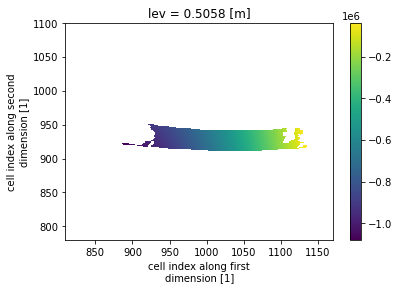

In [11]:
(ds_NAOp['longitude'] * dy).plot()

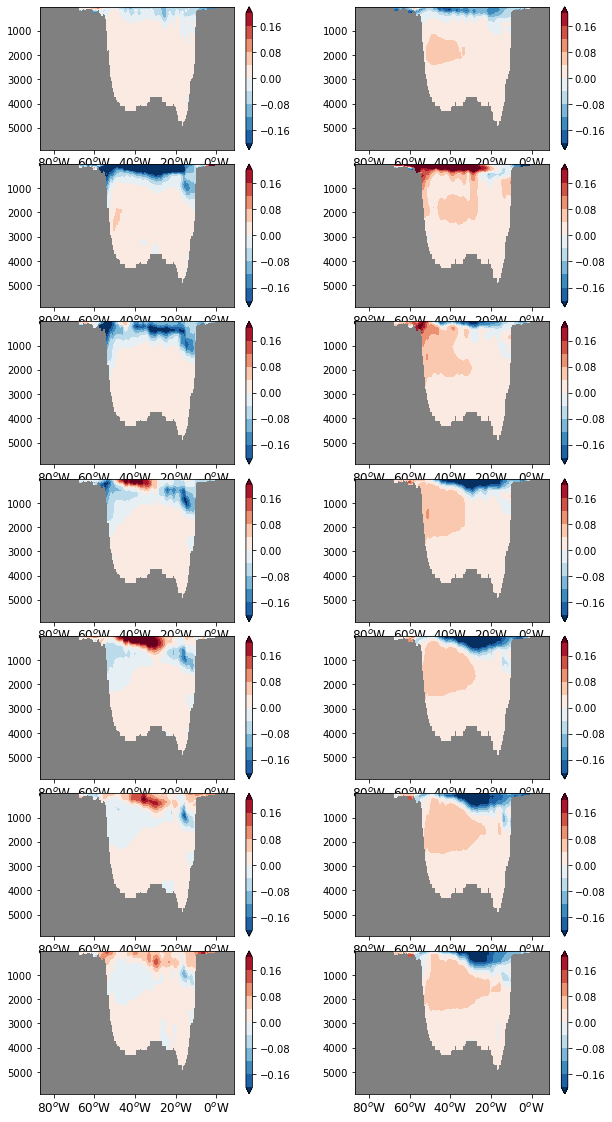

In [12]:
grid1 = plt.GridSpec(7, 2, wspace=0.3, hspace=0.1)
fig = plt.figure(figsize=[10,20])

for i in range(0,7):
    
    tmp = Temp_NAOp.isel(time=slice(12*i + 2, 12*i + 2 + 12)).mean('time') #- Temp.isel(time=0)
    
    ax = fig.add_subplot(grid1[i, 0],facecolor='grey')
    
    p = tmp.plot.contourf(ax=ax, x='i', y='lev', levels = 11, vmin = -0.2, vmax = 0.2,
                      cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
    cb = fig.colorbar(p, ax=ax, extend='both')
    plt.xticks(np.arange(-80,10,20), [r'$80^o$W', r'$60^o$W', r'$40^o$W', 
                                     r'$20^o$W', r'$0^o$W'], fontsize = 12);
    plt.gca().invert_yaxis()
    
    tmp = Temp_NAOn.isel(time=slice(12*i + 2, 12*i + 2 + 12)).mean('time') #- Temp.isel(time=0)
    
    ax = fig.add_subplot(grid1[i, 1],facecolor='grey')
    
    p = tmp.plot.contourf(ax=ax, x='i', y='lev', levels = 11, vmin = -0.2, vmax = 0.2,
                      cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
    cb = fig.colorbar(p, ax=ax, extend='both')
    plt.xticks(np.arange(-80,10,20), [r'$80^o$W', r'$60^o$W', r'$40^o$W', 
                                     r'$20^o$W', r'$0^o$W'], fontsize = 12);
    plt.gca().invert_yaxis()